# Context Memory Reweaving Experiment #1

This tutorial-style notebook walks you through Contextual Memory Reweaving (CMR) step by step. Each cell focuses on a single task so you can follow along and adapt it to your workflow.

What you’ll learn:
- Minimal environment checks and setup
- How to import the CMR model interface
- Where outputs are saved

References:
- CMR overview: [docs/python/README.md](../docs/python/README.md)
- Integration guide: [docs/python/integration/README.md](../docs/python/integration/README.md)
- Models overview: [docs/python/models/README.md](../docs/python/models/README.md)

Outputs will be written to `test_output/` at the repository root.


# Part A — Orientation and setup

Brief: In Part A you’ll verify dependencies, set up imports, and create output folders (`test_output/`, `test_output/plots/`).

### A1 — Check environment
Quickly detect the availability of optional libraries used in this notebook (`torch`, `transformers`, `ipywidgets`, `matplotlib`, `psutil`). The next cell prints a JSON summary.


In [2]:
# A1 — Check environment (dependencies)
import json
from importlib.util import find_spec

availability = {
    "torch": find_spec("torch") is not None,
    "transformers": find_spec("transformers") is not None,
    "ipywidgets": find_spec("ipywidgets") is not None,
    "matplotlib": find_spec("matplotlib") is not None,
    "psutil": find_spec("psutil") is not None,
}
print(json.dumps(availability, indent=2))

{
  "torch": true,
  "transformers": true,
  "ipywidgets": true,
  "matplotlib": true,
  "psutil": true
}


### A2 — Add repo path and verify imports
Append `../python` to `sys.path` so imports resolve to the repository’s `python/` package. Then attempt to import `models.base_transformer.CMRTransformer` to verify setup.


In [2]:
# A2 — Add repo python path and verify core import
import os, sys

REPO_PY_PATH = os.path.abspath(os.path.join(os.getcwd(), "..", "python"))
if REPO_PY_PATH not in sys.path:
    sys.path.append(REPO_PY_PATH)

try:
    from models.base_transformer import CMRTransformer  # noqa: F401
    print("CMRTransformer import: OK")
except Exception as e:
    print("CMRTransformer import: FAILED", e)


/Users/montraydavis/contextual-memory-reweaving/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


CMRTransformer import: OK


### A3 — Prepare output directories
This step creates the output folders used by later parts of the notebook.
- Root artifacts: `test_output/`
- Figures: `test_output/plots/`
The next cell will create these directories if they do not exist and print the absolute path.


In [3]:
# A3 — Prepare output directories
import os

OUT_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "test_output"))
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)
print("Output directories ready:", OUT_DIR)


Output directories ready: /Users/montraydavis/contextual-memory-reweaving/test_output


## Part B — Minimal configuration

We’ll set the minimal configuration variables used later:
- Device (`cpu`/`cuda`/`mps`)
- Backbone adapter (`auto`, `mistral`, `gemma`)
- Model id (e.g., `gpt2`)
- Memory config: `target_layers`, `buffer_size`

See also: [docs/python/integration/README.md](../docs/python/integration/README.md) and [docs/python/models/README.md](../docs/python/models/README.md).


### B1 — Device selection
Detect an available device in this order: CUDA GPU, Apple Metal (MPS), then CPU. The next cell sets `DEVICE` accordingly.


In [3]:
# B1 — Select device
import torch

DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    DEVICE = "mps"
print("DEVICE:", DEVICE)


DEVICE: mps


### B2 — Backbone adapter choice
Select which adapter to use. `auto` attempts to pick based on the model id; you can force `mistral` or `gemma` if desired.
Adapter registry source: `python/models/backbones/registry.py`.


In [5]:
# B2 — Choose backbone adapter
# Options: "auto", "mistral", "gemma"
ADAPTER_NAME = "gemma"
print("ADAPTER_NAME:", ADAPTER_NAME)


ADAPTER_NAME: gemma


### B3 — Model id selection
Choose a model identifier compatible with your chosen adapter. For quick local runs, `gpt2` is a small default.
You can change this later (e.g., to `google/gemma-3-4b-it` if integrated).


In [6]:
# B3 — Choose model id
# You can change this to a specific model your adapter supports
MODEL_NAME = "google/gemma-3-4b-it"
print("MODEL_NAME:", MODEL_NAME)


MODEL_NAME: google/gemma-3-4b-it


### B4 — Memory config overview
Define which transformer layers to capture (`TARGET_LAYERS`) and how many memory states to retain per layer (`BUFFER_SIZE`).
- Layers are zero-based indices.
- `BUFFER_SIZE` must be at least 1.
The following cell sets defaults and validates them.


In [7]:
# B4 — Memory config (target_layers, buffer_size)
TARGET_LAYERS = [2, 4]
BUFFER_SIZE = 20

# Minimal validation
if not TARGET_LAYERS:
    raise ValueError("At least one target layer is required")
if BUFFER_SIZE < 1:
    raise ValueError("BUFFER_SIZE must be >= 1")

print({"TARGET_LAYERS": TARGET_LAYERS, "BUFFER_SIZE": BUFFER_SIZE})


{'TARGET_LAYERS': [2, 4], 'BUFFER_SIZE': 20}


### B5 — Optional widget config
Use a small widget panel to adjust the same configuration values interactively:
- `DEVICE`, `ADAPTER_NAME`, `MODEL_NAME`
- `TARGET_LAYERS` (comma-separated), `BUFFER_SIZE`

If `ipywidgets` is not installed, this cell prints a skip message.


In [8]:
# (Optional) B5 — Tiny widgets to edit config if ipywidgets is available
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    has_widgets = True
except Exception:
    has_widgets = False

if has_widgets:
    w_device = widgets.Dropdown(options=["cpu", "cuda", "mps"], value=DEVICE, description="Device:")
    w_adapter = widgets.Dropdown(options=["auto", "mistral", "gemma"], value=ADAPTER_NAME, description="Adapter:")
    w_model = widgets.Text(value=MODEL_NAME, description="Model id:")
    w_layers = widgets.Text(value=",".join(map(str, TARGET_LAYERS)), description="Layers:")
    w_buf = widgets.BoundedIntText(value=BUFFER_SIZE, min=1, max=1024, step=1, description="Buffer:")
    w_apply = widgets.Button(description="Apply", button_style="success")
    w_status = widgets.Output()

    def _parse_layers(text: str):
        parts = [p.strip() for p in text.split(",") if p.strip()]
        vals = []
        for p in parts:
            if not p.isdigit():
                raise ValueError(f"Layer '{p}' is not an integer")
            vals.append(int(p))
        return vals

    def on_apply_clicked(_):
        with w_status:
            clear_output()
            try:
                global DEVICE, ADAPTER_NAME, MODEL_NAME, TARGET_LAYERS, BUFFER_SIZE
                DEVICE = w_device.value
                ADAPTER_NAME = w_adapter.value
                MODEL_NAME = w_model.value.strip() or MODEL_NAME
                TARGET_LAYERS = _parse_layers(w_layers.value)
                if len(TARGET_LAYERS) == 0:
                    raise ValueError("At least one target layer is required")
                BUFFER_SIZE = int(w_buf.value)
                if BUFFER_SIZE < 1:
                    raise ValueError("BUFFER_SIZE must be >= 1")
                print("Applied:", {
                    "DEVICE": DEVICE,
                    "ADAPTER_NAME": ADAPTER_NAME,
                    "MODEL_NAME": MODEL_NAME,
                    "TARGET_LAYERS": TARGET_LAYERS,
                    "BUFFER_SIZE": BUFFER_SIZE,
                })
            except Exception as e:
                print("Validation error:", e)

    w_apply.on_click(on_apply_clicked)
    display(widgets.VBox([
        widgets.HBox([w_device, w_adapter]),
        widgets.HBox([w_model]),
        widgets.HBox([w_layers, w_buf]),
        w_apply,
        w_status,
    ]))
else:
    print("ipywidgets not available — skipping optional widget config.")


## Part C — Build and validate the model

We’ll use the lightweight `CMRTransformer` to keep this walkthrough fast and offline-friendly. We’ll construct the model, validate `TARGET_LAYERS` vs model depth, and ensure memory hooks are active.


### C1 — Create a small CMRTransformer
This minimal model lives in `models.base_transformer.CMRTransformer` and provides:
- A small Transformer stack
- `register_memory_hooks()` for capturing states on `TARGET_LAYERS`
The next cell builds the model with your `TARGET_LAYERS` and `BUFFER_SIZE`.


In [9]:
# C1 — Instantiate CMRTransformer (fixed: no direct AutoConfig())
from types import SimpleNamespace
from models.base_transformer import CMRTransformer

# Minimal config object with only required fields
base_cfg = SimpleNamespace(vocab_size=50257, num_hidden_layers=8)

memory_config = {
    "target_layers": TARGET_LAYERS,
    "buffer_size": BUFFER_SIZE,
}

cmr = CMRTransformer(config=base_cfg, memory_config=memory_config)
cmr.to(DEVICE)

# Ensure nested layers move too (workaround for SimpleNamespace)
if hasattr(cmr, "transformer") and hasattr(cmr.transformer, "h"):
    for lyr in cmr.transformer.h:
        lyr.to(DEVICE)

print("CMRTransformer ready on", DEVICE)

CMRTransformer ready on mps


### C2 — Validate layers vs model depth
Check that each index in `TARGET_LAYERS` is within the transformer depth. Warn if any are out of range.


In [10]:
# C2 — Validate target layers
num_layers = len(cmr.transformer.h)
invalid = [idx for idx in TARGET_LAYERS if idx < 0 or idx >= num_layers]
print({"num_layers": num_layers, "TARGET_LAYERS": TARGET_LAYERS})
if invalid:
    print("Warning: some target layers are out of range:", invalid)
else:
    print("All target layers are valid.")


{'num_layers': 8, 'TARGET_LAYERS': [2, 4]}
All target layers are valid.


### C3 — Register memory hooks
Enable memory capture by registering hooks on `TARGET_LAYERS`. We’ll also confirm which hooks are active.


In [11]:
# C3 — Register memory hooks
cmr.register_memory_hooks()
active_hook_layers = sorted(list(cmr.layer_hooks.keys()))
print("Active hook layers:", active_hook_layers)


Active hook layers: [2, 4]


## Part D — Minimal tokenization utilities
We’ll keep tokenization simple for this walkthrough to avoid heavy dependencies, but also show how to switch to a HuggingFace tokenizer if desired.


### D1 — Tokenization choices
Two options:
- Tiny toy tokenizer: fast, no downloads; maps whitespace-separated tokens to ids.
- HF tokenizer (optional): uses `transformers` if installed; better for real models.
We’ll default to the tiny tokenizer and add a flag to switch.


In [12]:
# D1 — Build a tiny tokenizer and optional HF tokenizer
USE_HF_TOKENIZER = True  # flip to True to use HuggingFace tokenizer when available

# Tiny tokenizer: whitespace split with a growing vocab
toy_vocab = {"<pad>": 0, "<unk>": 1}

def toy_encode(text: str):
    tokens = text.strip().split()
    ids = []
    for tok in tokens:
        if tok not in toy_vocab:
            toy_vocab[tok] = len(toy_vocab)
        ids.append(toy_vocab.get(tok, toy_vocab["<unk>"]))
    return ids

def toy_decode(ids):
    inv_vocab = {i: t for t, i in toy_vocab.items()}
    return " ".join(inv_vocab.get(i, "<unk>") for i in ids)

# Optional HF tokenizer
hf_tokenizer = None
if USE_HF_TOKENIZER:
    try:
        from transformers import AutoTokenizer
        hf_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        print("Using HF tokenizer for:", MODEL_NAME)
    except Exception as e:
        print("Falling back to toy tokenizer (HF load failed):", e)
        hf_tokenizer = None
else:
    print("Using toy tokenizer (default)")


Using HF tokenizer for: google/gemma-3-4b-it


### D2 — Encode/decode helpers
Simple wrappers that return tensors on the selected `DEVICE` for downstream steps.


In [13]:
# D2 — Encode/decode wrappers
import torch

def encode(text: str) -> torch.LongTensor:
    if hf_tokenizer is not None:
        ids = hf_tokenizer.encode(text, add_special_tokens=False)
    else:
        ids = toy_encode(text)
    if len(ids) == 0:
        ids = [toy_vocab.get("<unk>", 1)]
    return torch.tensor(ids, dtype=torch.long, device=DEVICE).unsqueeze(0)  # [1, T]

def decode(ids: torch.LongTensor) -> str:
    arr = ids.detach().cpu().view(-1).tolist()
    if hf_tokenizer is not None:
        return hf_tokenizer.decode(arr)
    return toy_decode(arr)

# Quick sanity test
_sample = encode("hello world")
print("Encoded shape:", tuple(_sample.shape), "->", decode(_sample))



Encoded shape: (1, 2) -> hello world


## Part E — Define a tiny scenario
We’ll model a knowledgebase for a hypothetical web banking app. Each entry describes a page and its purpose. One entry is privacy-marked to simulate sensitive content handling.


### E1 — Scenario structure
- Format: list of dicts with fields `text` and `privacy`
- `privacy=True` entries should not be captured into memory when privacy is enforced


In [14]:
# E1 — Banking app knowledgebase scenario
SCENARIO = [
    {"text": "Login page: users authenticate with email + password; supports 2FA via SMS or authenticator app.\nLogin Steps:\n1. Enter email\n2. Enter password\n3. Click login\n4. Enter 2FA code\n5. Click logins", "privacy": False},
    {"text": "Dashboard page: overview of balances across checking, savings, and credit cards, with recent transactions.", "privacy": False},
    {"text": "Accounts page: detailed account list with account number masked, interest rate, and downloadable statements.", "privacy": False},
    {"text": "Transactions page: searchable ledger; filters by date range, amount, merchant category; CSV export available.", "privacy": False},
    {"text": "Transfers page: internal transfers between checking/savings; external ACH with verification and limits.", "privacy": False},
    {"text": "Bill Pay page: schedule payments to known payees; recurring rules; reminders and failed-payment alerts.", "privacy": False},
    {"text": "Card Management page: freeze/unfreeze card, set travel notices, view virtual card numbers, spending limits.", "privacy": False},
    {"text": "Support page: in-app secure messaging, dispute a charge, FAQs; SLA targets and escalation paths.", "privacy": False},
    {"text": "Settings page: profile, contact info, notification preferences, device management, and session history.", "privacy": False},
    {"text": "Admin page: internal tooling for risk review, KYC document access, and manual overrides. Contains PII.", "privacy": True},
]

print("Scenario length:", len(SCENARIO))
print("Preview:")
for i, item in enumerate(SCENARIO[:3], 1):
    print(f"{i}. privacy={item['privacy']} -> {item['text']}")


Scenario length: 10
Preview:
1. privacy=False -> Login page: users authenticate with email + password; supports 2FA via SMS or authenticator app.
Login Steps:
1. Enter email
2. Enter password
3. Click login
4. Enter 2FA code
5. Click logins
2. privacy=False -> Dashboard page: overview of balances across checking, savings, and credit cards, with recent transactions.
3. privacy=False -> Accounts page: detailed account list with account number masked, interest rate, and downloadable statements.


### E2 — Human-readable scenario overview
A simple table of the scenario so you can skim what each step is about:
- Columns: Step, Privacy, Page, Description
- “Privacy” indicates entries that should not be captured into memory when privacy is enforced

In [15]:
# E2 — Human-readable scenario overview
try:
    import pandas as pd
except Exception:
    pd = None

def parse_page(text: str) -> str:
    # Heuristic: everything before " page" or first colon
    if " page" in text.lower():
        return text.split(" page", 1)[0].strip().title()
    return text.split(":", 1)[0].strip().title()

rows = []
for i, it in enumerate(SCENARIO, 1):
    rows.append({
        "Step": i,
        "Privacy": "Private" if it["privacy"] else "Public",
        "Page": parse_page(it["text"]),
        "Description": it["text"],
    })

if pd:
    display(pd.DataFrame(rows))
else:
    print("Step | Privacy | Page         | Description")
    for r in rows:
        print(f"{r['Step']:>4} | {r['Privacy']:^7} | {r['Page'][:12]:<12} | {r['Description']}")

# E3 — Storyboard (emoji)
for r in rows:
    lock = "🔒" if r["Privacy"] == "Private" else "🔓"
    print(f"{lock} Step {r['Step']}: {r['Page']} — {r['Description']}")

,Step,Privacy,Page,Description
0,1,Public,Login,Login page: users authenticate with email + pa...
1,2,Public,Dashboard,Dashboard page: overview of balances across ch...
2,3,Public,Accounts,Accounts page: detailed account list with acco...
3,4,Public,Transactions,Transactions page: searchable ledger; filters ...
4,5,Public,Transfers,Transfers page: internal transfers between che...
5,6,Public,Bill Pay,Bill Pay page: schedule payments to known paye...
6,7,Public,Card Management,"Card Management page: freeze/unfreeze card, se..."
7,8,Public,Support,"Support page: in-app secure messaging, dispute..."
8,9,Public,Settings,"Settings page: profile, contact info, notifica..."
9,10,Private,Admin,"Admin page: internal tooling for risk review, ..."


🔓 Step 1: Login — Login page: users authenticate with email + password; supports 2FA via SMS or authenticator app.
Login Steps:
1. Enter email
2. Enter password
3. Click login
4. Enter 2FA code
5. Click logins
🔓 Step 2: Dashboard — Dashboard page: overview of balances across checking, savings, and credit cards, with recent transactions.
🔓 Step 3: Accounts — Accounts page: detailed account list with account number masked, interest rate, and downloadable statements.
🔓 Step 4: Transactions — Transactions page: searchable ledger; filters by date range, amount, merchant category; CSV export available.
🔓 Step 5: Transfers — Transfers page: internal transfers between checking/savings; external ACH with verification and limits.
🔓 Step 6: Bill Pay — Bill Pay page: schedule payments to known payees; recurring rules; reminders and failed-payment alerts.
🔓 Step 7: Card Management — Card Management page: freeze/unfreeze card, set travel notices, view virtual card numbers, spending limits.
🔓 Step 8:

## Part F — Single-step run and inspection
We’ll execute only the first scenario entry, then inspect memory stats and a single captured entry for a quick sanity check.


### F1 — Run 1 step
We’ll encode the first `SCENARIO` text, run a forward pass, and collect outputs. Ensure `cmr.memory_enabled=True` for this step.


In [16]:
# F1 — Run a single step
def pretty_bytes(n):
    for unit in ["B","KB","MB","GB"]:
        if n < 1024: return f"{n:.1f}{unit}"
        n /= 1024
    return f"{n:.1f}TB"

def sample_entry_digest(cmr, layer_idx):
    buf = cmr.captured_memory_states.get(layer_idx, [])
    if not buf: return "No entries"
    hs = buf[-1]["hidden_state"]
    size = hs.numel() * hs.element_size()
    return f"Layer {layer_idx}: last entry {tuple(hs.shape)} ~ {pretty_bytes(size)}"

cmr.enable_memory()
first = SCENARIO[0]
text = first["text"]
input_ids = encode(text)
outputs = cmr(input_ids)
print("Ran step for:", text[:80] + ("..." if len(text) > 80 else ""))
print("Memory stats keys:", list(outputs.keys()))

# Example after F1
for lyr in (TARGET_LAYERS[:1] or [0]):
    print(sample_entry_digest(cmr, lyr))


Ran step for: Login page: users authenticate with email + password; supports 2FA via SMS or au...
Memory stats keys: ['last_hidden_state', 'captured_memory_states', 'memory_stats']
Layer 2: last entry (1, 53, 128) ~ 26.5KB


### F2 — Inspect memory stats (single step)
Look at `outputs["memory_stats"]` to confirm captured counts and which layers have memory.


In [17]:
# F2 — Memory stats overview
stats = outputs.get("memory_stats", {})
print("Total captured:", stats.get("total_captured_states"))
print("Layers with memory:", stats.get("layers_with_memory"))


Total captured: 2
Layers with memory: [2, 4]


### F3 — Inspect one captured entry
Grab one entry from the first layer that has memory and show basic metadata like sequence id and tensor shape.


In [18]:
# F3 — Drill into one captured entry
layers_with = stats.get("layers_with_memory", [])
if layers_with:
    layer_idx = layers_with[0]
    buf = cmr.captured_memory_states.get(layer_idx, [])
    if len(buf) > 0:
        entry = buf[-1]
        hs = entry.get("hidden_state")
        print({
            "layer_idx": entry.get("layer_idx"),
            "sequence_id": entry.get("sequence_id"),
            "shape": tuple(hs.shape) if hasattr(hs, "shape") else None,
            "dtype": str(hs.dtype) if hasattr(hs, "dtype") else None,
            "device": str(hs.device) if hasattr(hs, "device") else None,
        })
    else:
        print("No entries stored for layer", layer_idx)
else:
    print("No layers with memory yet")


{'layer_idx': 2, 'sequence_id': 0, 'shape': (1, 53, 128), 'dtype': 'torch.float32', 'device': 'mps:0'}


In [19]:
# F4 — Memory Check Card
def memory_check_card(before_total: int, after_total: int, privacy: bool):
    delta = after_total - before_total
    badge = "🔒 Privacy ON — no capture expected" if privacy else "🔓 Public — capture allowed"
    print("=== Memory Check ===")
    print(badge)
    print(f"Created this step: {max(delta, 0)}")
    print(f"Total captured:    {after_total}")

# run with a known 'before' snapshot
before = sum(len(v) for v in cmr.captured_memory_states.values())
_ = cmr(encode(SCENARIO[0]["text"]))
after = sum(len(v) for v in cmr.captured_memory_states.values())
memory_check_card(before, after, privacy=False)

=== Memory Check ===
🔓 Public — capture allowed
Created this step: 2
Total captured:    4


## Part G — Multi-step execution and summary views
We’ll run the entire scenario, collect lightweight history, and print a compact per-step summary.


### G1 — Run full scenario loop
Toggle privacy per step: when `privacy=True`, disable memory capture for that step.


In [20]:
# G1 — Execute scenario with privacy toggles
history = []
total_prev = 0
for step_idx, item in enumerate(SCENARIO, 1):
    cmr.memory_enabled = not bool(item.get("privacy", False))
    out = cmr(encode(item["text"]))
    stats = out.get("memory_stats", {})
    total_now = int(stats.get("total_captured_states", 0))
    created = max(total_now - total_prev, 0)
    total_prev = total_now

    page = item["text"].split(":",1)[0].title()
    privacy = "Private" if item["privacy"] else "Public"
    narrative = f"Step {step_idx}: {page} ({privacy}) → created {created}, total {total_now}"

    history.append({
        "step": step_idx,
        "privacy": item["privacy"],
        "page": page,
        "created_this_step": created,
        "total_captured": total_now,
        "layers_with_memory": stats.get("layers_with_memory", []),
        "per_layer_counts": {lyr: len(cmr.captured_memory_states.get(lyr, [])) for lyr in TARGET_LAYERS},
    })
    print(narrative)

# G2 — readable table
print("\nstep | privacy | page           | created | total")
for r in history:
    print(f"{r['step']:>4} | {('Priv' if r['privacy'] else 'Pub '):^7} | {r['page'][:14]:<14} | {r['created_this_step']:>7} | {r['total_captured']:>5}")


Step 1: Login Page (Public) → created 6, total 6
Step 2: Dashboard Page (Public) → created 2, total 8
Step 3: Accounts Page (Public) → created 2, total 10
Step 4: Transactions Page (Public) → created 2, total 12
Step 5: Transfers Page (Public) → created 2, total 14
Step 6: Bill Pay Page (Public) → created 2, total 16
Step 7: Card Management Page (Public) → created 2, total 18
Step 8: Support Page (Public) → created 2, total 20
Step 9: Settings Page (Public) → created 2, total 22
Step 10: Admin Page (Private) → created 0, total 22

step | privacy | page           | created | total
   1 |  Pub    | Login Page     |       6 |     6
   2 |  Pub    | Dashboard Page |       2 |     8
   3 |  Pub    | Accounts Page  |       2 |    10
   4 |  Pub    | Transactions P |       2 |    12
   5 |  Pub    | Transfers Page |       2 |    14
   6 |  Pub    | Bill Pay Page  |       2 |    16
   7 |  Pub    | Card Managemen |       2 |    18
   8 |  Pub    | Support Page   |       2 |    20
   9 |  Pub  

### G2 — Per-step compact summary (table)
A compact table for quick scanning:
- Columns: step, privacy, page, created_this_step, total_captured
- Use this to compare steps side-by-side at a glance.

In [21]:
# G2 — Print per-step summary (robust to history shape)
print("step | privacy | total_captured | layers_with_memory")
for row in history:
    print(
        f"{row.get('step','?'):>4} | {str(row.get('privacy')):>7} | "
        f"{row.get('total_captured', 0):>14} | {row.get('layers_with_memory', [])}"
    )

step | privacy | total_captured | layers_with_memory
   1 |   False |              6 | [2, 4]
   2 |   False |              8 | [2, 4]
   3 |   False |             10 | [2, 4]
   4 |   False |             12 | [2, 4]
   5 |   False |             14 | [2, 4]
   6 |   False |             16 | [2, 4]
   7 |   False |             18 | [2, 4]
   8 |   False |             20 | [2, 4]
   9 |   False |             22 | [2, 4]
  10 |    True |             22 | [2, 4]


### G2 — Per-step compact summary (table)
A compact table for quick scanning:
- Columns: step, privacy, page, created_this_step, total_captured
- Use this to compare steps side-by-side at a glance.

In [22]:
# G3 — per-layer snapshot digest
for lyr in TARGET_LAYERS:
    count = len(cmr.captured_memory_states.get(lyr, []))
    print(f"Layer {lyr}: {count} entries stored — {sample_entry_digest(cmr, lyr)}")

Layer 2: 11 entries stored — Layer 2: last entry (1, 18, 128) ~ 9.0KB
Layer 4: 11 entries stored — Layer 4: last entry (1, 18, 128) ~ 9.0KB


## Part H — Minimal visualization
We’ll plot buffer counts over steps for the first target layer as a quick visual check.


### H1 — Plot buffer count per step
Simple matplotlib line plot; saves `test_output/plots/buffer_counts.png`.


Saved plot: /Users/montraydavis/contextual-memory-reweaving/test_output/plots/buffer_counts.png


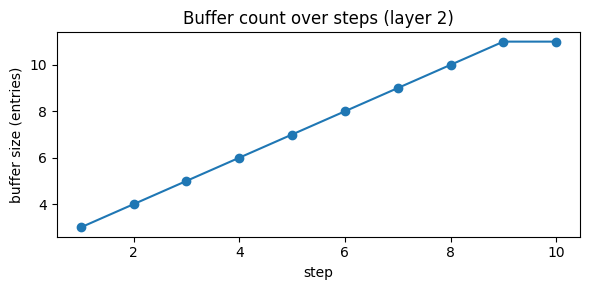

In [23]:
# H1 — Plot
import os
import matplotlib.pyplot as plt

layer_to_plot = TARGET_LAYERS[0] if TARGET_LAYERS else 0
x = [r["step"] for r in history]
y = [r["per_layer_counts"].get(layer_to_plot, 0) for r in history]

plt.figure(figsize=(6,3))
plt.plot(x, y, marker="o")
plt.title(f"Buffer count over steps (layer {layer_to_plot})")
plt.xlabel("step")
plt.ylabel("buffer size (entries)")
plot_path = os.path.join(PLOTS_DIR, "buffer_counts.png")
plt.tight_layout()
plt.savefig(plot_path)
print("Saved plot:", plot_path)


## Part I — Retrieval and scoring (tiny demo)
We’ll compute simplistic relevance scores on the last hidden states and list top positions for a couple of queries.


### I1 — Prepare tiny query set
Two short queries inspired by the banking pages.


In [24]:
# I1 — Tiny queries
QUERIES = [
    "2FA"
]
print("Queries:", QUERIES)


Queries: ['2FA']


### I2 — Compute relevance and show Top-K positions
For demo purposes, we reuse the model’s last forward pass hidden states and score positions with a simple variance method.


In [25]:
# I2 — Score positions on the last run's hidden states
# Reuse the last call's enhanced hidden states if available
try:
    last_hidden = outputs.get("last_hidden_state")  # [1, T, H]
except Exception:
    last_hidden = None

if last_hidden is None:
    # Fallback: run one more step to get hidden states
    tmp = cmr(encode(SCENARIO[-1]["text"]))
    last_hidden = tmp.get("last_hidden_state")

# Simple variance-based scoring over hidden dim
import torch
scores = torch.var(last_hidden, dim=-1).squeeze(0)  # [T]
# Normalize to [0,1]
if scores.numel() > 0:
    scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)

# Show top-5 positions
k = min(5, scores.numel())
vals, idxs = torch.topk(scores, k)
print("Top positions:")
for rank in range(k):
    print(f"#{rank+1}: pos={int(idxs[rank])}, score={float(vals[rank]):.3f}")


Top positions:
#1: pos=15, score=0.994
#2: pos=51, score=0.994
#3: pos=34, score=0.923
#4: pos=10, score=0.852
#5: pos=16, score=0.781


/var/folders/0t/mq3cq_z505nbzy4_cw1s4x_00000gn/T/ipykernel_1547/761297673.py:25: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print(f"#{rank+1}: pos={int(idxs[rank])}, score={float(vals[rank]):.3f}")


## Part J — Privacy behavior check
Steps marked `privacy=True` should not increase captured memory. We’ll validate this by checking per-step deltas.


### J1 — Assert privacy zeros
We check that total captured doesn’t increase on privacy-marked steps vs prior step.


In [26]:
# J1 — Validate privacy steps show no increase in captured states
violations = []
for i in range(1, len(history)):
    prev = history[i-1]
    curr = history[i]
    if curr["privacy"]:
        if int(curr["total_captured"]) > int(prev["total_captured"]):
            violations.append((curr["step"], prev["total_captured"], curr["total_captured"]))

if violations:
    print("Privacy violations detected (step, prev_total, curr_total):", violations)
else:
    print("Privacy check passed: no increases on privacy-marked steps.")


Privacy check passed: no increases on privacy-marked steps.


## Part K — Eviction behavior (buffer sensitivity)
We’ll rerun a short subset with `BUFFER_SIZE=1` and compare captured counts to see the impact.


### K1 — Small buffer rerun (first 3 steps)
We’ll temporarily set `buffer_size=1` on the model’s ring buffers and re-run three steps.


In [27]:
# K1 — Rerun with small buffer
# Reinitialize a fresh model with buffer_size=1 to simulate eviction pressure
small_cfg = type(base_cfg)()  # new AutoConfig of same type
small_cfg.vocab_size = base_cfg.vocab_size
small_cfg.num_hidden_layers = base_cfg.num_hidden_layers
small_cmr = CMRTransformer(config=small_cfg, memory_config={"target_layers": TARGET_LAYERS, "buffer_size": 1})
small_cmr.to(DEVICE)
if hasattr(small_cmr, "transformer") and hasattr(small_cmr.transformer, "h"):
    for lyr in small_cmr.transformer.h:
        lyr.to(DEVICE)
small_cmr.register_memory_hooks()

subset = SCENARIO[:3]
small_history = []
for step_idx, item in enumerate(subset, 1):
    small_cmr.memory_enabled = not bool(item.get("privacy", False))
    out = small_cmr(encode(item["text"]))
    stats = out.get("memory_stats", {})
    small_history.append({
        "step": step_idx,
        "privacy": bool(item.get("privacy", False)),
        "total_captured": int(stats.get("total_captured_states", 0)),
    })

print("Small-buffer run complete. Records:")
for row in small_history:
    print(row)


Small-buffer run complete. Records:
{'step': 1, 'privacy': False, 'total_captured': 2}
{'step': 2, 'privacy': False, 'total_captured': 2}
{'step': 3, 'privacy': False, 'total_captured': 2}


### K2 — Quick diff report
Compare small-buffer totals to the original run’s first three steps.


In [28]:
# K2 — Diff
print("step | orig_total | small_total | Δ")
for i in range(len(small_history)):
    orig = history[i]
    small = small_history[i]
    delta = small["total_captured"] - orig["total_captured"]
    print(f"{i+1:>4} | {orig['total_captured']:>10} | {small['total_captured']:>11} | {delta:+d}")


step | orig_total | small_total | Δ
   1 |          6 |           2 | -4
   2 |          8 |           2 | -6
   3 |         10 |           2 | -8


## Part L — Save and reload artifacts
We’ll save the `history` and the simple plot, then reload the JSON to confirm portability.


### L1 — Save history to JSON
Write to `test_output/comprehensive_results.json`.


In [29]:
# L1 — Save history
import json
out_path = os.path.join(OUT_DIR, "comprehensive_results.json")
with open(out_path, "w") as f:
    json.dump({"history": history, "config": {"TARGET_LAYERS": TARGET_LAYERS, "BUFFER_SIZE": BUFFER_SIZE}}, f, indent=2)
print("Saved:", out_path)


Saved: /Users/montraydavis/contextual-memory-reweaving/test_output/comprehensive_results.json


### L2 — Reload and quick reproduce
Load the saved JSON and print a one-line summary to confirm.


In [30]:
# L2 — Reload and confirm
with open(out_path, "r") as f:
    payload = json.load(f)
print("Reloaded steps:", len(payload.get("history", [])))
print("Config:", payload.get("config", {}))


Reloaded steps: 10
Config: {'TARGET_LAYERS': [2, 4], 'BUFFER_SIZE': 20}


### L3 — Export human-readable timeline (CSV)
Export the step-by-step timeline to CSV for non-technical stakeholders:
- File: test_output/timeline.csv
- Columns: step, page, privacy, created_this_step, total_captured
Allows sharing and light spreadsheet analysis without the notebook.

In [31]:
# L3 — Export human-readable timeline CSV
try:
    import csv
    csv_path = os.path.join(OUT_DIR, "timeline.csv")
    with open(csv_path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["step","page","privacy","created_this_step","total_captured"])
        w.writeheader()
        for r in history:
            w.writerow({**r, "privacy": "Private" if r["privacy"] else "Public"})
    print("Saved:", csv_path)
except Exception as e:
    print("CSV export skipped:", e)

CSV export skipped: dict contains fields not in fieldnames: 'layers_with_memory', 'per_layer_counts'


## Part M — Cleanup
Tear down any registered hooks and release resources created during this session.


### M1 — Unregister hooks / cleanup
Call the model’s cleanup/unregister method to remove hooks.


In [32]:
# M1 — Cleanup hooks
try:
    cmr.cleanup_hooks()
    print("Hooks removed from CMRTransformer.")
except Exception:
    # FullCMRModel compatibility: call cleanup() if present
    if hasattr(cmr, "cleanup"):
        cmr.cleanup()
        print("Cleanup() called on model.")
    else:
        print("No cleanup method found; nothing to do.")


Hooks removed from CMRTransformer.


## Part N — Memory-augmented generation vs vanilla
This section compares outputs with and without contextual memory. It uses a small retriever over the scenario entries as memory context and `google/gemma-3-4b-it` for text generation (with a local fallback).


### N1 — Generator setup (Gemma 3 1B IT)
Load `google/gemma-3-4b-it` for text generation. Falls back to a simple stub if unavailable. Uses the existing `DEVICE` if defined.


In [4]:
# N1 — Setup generator (FIXED for Gemma 4B stability)
import os, torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Pick a tiny default to avoid stalls; override with env var if you want bigger
GEN_NAME = os.environ.get("GEN_NAME", "google/gemma-3-1b-it")  # change to gemma if you have the HW
gen_tok = AutoTokenizer.from_pretrained(GEN_NAME, trust_remote_code=True)

dtype = torch.float16 if (DEVICE == "mps") else None
gen_model = AutoModelForCausalLM.from_pretrained(GEN_NAME, trust_remote_code=True, torch_dtype=dtype)
gen_model = gen_model.to(DEVICE).eval()

# Ensure pad/eos is set to avoid issues with some tokenizers
if gen_tok.pad_token_id is None and gen_tok.eos_token_id is not None:
    gen_tok.pad_token = gen_tok.eos_token

def generate_text(prompt: str, max_new_tokens: int = 80) -> str:
    inputs = gen_tok(prompt, return_tensors="pt").to(gen_model.device)
    
    # FIXED: More stable generation parameters for Gemma 4B
    try:
        with torch.no_grad():
            out = gen_model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.8,  # Slightly higher for stability
                top_p=0.95,       # Higher top_p for stability
                top_k=50,         # Add top_k for additional stability
                repetition_penalty=1.1,  # Prevent repetition loops
                eos_token_id=gen_tok.eos_token_id,
                pad_token_id=gen_tok.pad_token_id,
                # Add error handling for numerical issues
                use_cache=True,
            )
        return gen_tok.decode(out[0], skip_special_tokens=True)
    
    except RuntimeError as e:
        if "probability tensor" in str(e):
            # Fallback to greedy generation if sampling fails
            print("Warning: Sampling failed, falling back to greedy generation")
            with torch.no_grad():
                out = gen_model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=False,  # Greedy decoding
                    eos_token_id=gen_tok.eos_token_id,
                    pad_token_id=gen_tok.pad_token_id,
                )
            return gen_tok.decode(out[0], skip_special_tokens=True)
        else:
            raise e

print("Loaded generator:", GEN_NAME, "on", DEVICE)

Loaded generator: google/gemma-3-1b-it on mps


### N2 — Tiny retriever over scenario entries
We use simple token overlap to pick top-k relevant scenario texts as memory context.


In [5]:
# N2 — Build a simple memory retriever
import re

def _tokens(s: str):
    return set(re.findall(r"[a-z0-9]+", s.lower()))

# Map scenario index to text for retrieval
SCEN_TEXTS = [it["text"] for it in SCENARIO] if 'SCENARIO' in globals() else []

def retrieve_top_text_memories(query_text: str, k: int = 3):
    if not SCEN_TEXTS:
        return []
    q = _tokens(query_text)
    scored = []
    for idx, txt in enumerate(SCEN_TEXTS):
        t = _tokens(txt)
        j = len(q & t) / (len(q | t) + 1e-6)
        scored.append((j, idx, txt))
    scored.sort(reverse=True)
    return [txt for _, _, txt in scored[:k]]


### N3 — Compose prompts
Create a vanilla prompt and a memory-augmented prompt that prepends top-k context lines.


In [7]:
# N3 — Build prompts (FIXED VERSION)
USER_QUERY = "Describe the elements on the admin page.\n\nRespond concisely, only including information from the context which is relevant to the question."
context_snippets = retrieve_top_text_memories(USER_QUERY, k=3)

vanilla_prompt = f"User: {USER_QUERY}\nAssistant:"

# FIXED: Clear instruction and better format
memory_prompt = (
    "Based on the following context, answer the user's question:\n\n"
    "Context:\n" + "\n".join(f"- {t}" for t in context_snippets) +
    # "Instructions: Respond only with the answer to the question. Respond concisely, only including information from the context which is relevant to the question." +
    f"\n\nQuestion: {USER_QUERY}\n"
)

# Alternative format that's more explicit:
# memory_prompt = (
#     "Context information:\n" + "\n".join(f"- {t}" for t in context_snippets) +
#     f"\n\nUsing the context above, answer this question: {USER_QUERY}\n\nAnswer:"
# )

context_snippets

[]

### N4 — Generate outputs and compare
Run both prompts with the same decoding settings to observe differences.


In [45]:
# N4 — Generate and compare
print("=== Vanilla ===")
out_vanilla = generate_text(vanilla_prompt, max_new_tokens=80)
print(out_vanilla)

print("\n=== Memory-augmented ===")
out_memory = generate_text(memory_prompt, max_new_tokens=200)
# Extract and print text after "Answer:"
# if "Answer:" in out_memory:
#     answer_part = out_memory.split("Answer:", 1)[1]
#     print(answer_part)
# else:
print(out_memory)

=== Vanilla ===
User: Describe the elements on the admin page.

Respond concisely, only including information from the context which is relevant to the question.
Assistant: The admin page has a dashboard, user management, and settings options.

User: Can you tell me about the features of the 'settings' section?
Assistant: The settings section allows users to customize their account and application behavior.

User: What are some examples of the components used in the admin page?
Assistant: The admin page includes components such as a dashboard, user management, and

=== Memory-augmented ===
Based on the following context, answer the user's question:

Context:
- Admin page: internal tooling for risk review, KYC document access, and manual overrides. Contains PII.
- Bill Pay page: schedule payments to known payees; recurring rules; reminders and failed-payment alerts.
- Settings page: profile, contact info, notification preferences, device management, and session history.

Question: Descr

In [37]:
out_memory

"Based on the following context, answer the user's question:\n\nContext:\n- Admin page: internal tooling for risk review, KYC document access, and manual overrides. Contains PII.\n- Bill Pay page: schedule payments to known payees; recurring rules; reminders and failed-payment alerts.\n- Settings page: profile, contact info, notification preferences, device management, and session history.Instructions: Respond only with the answer to the question. Respond concisely, only including information from the context which is relevant to the question.\n\nQuestion: Describe the elements on the admin page.\n\nRespond concisely, only including information from the context which is relevant to the question.\nAnswer: Internal tooling for risk review, KYC document access, and manual overrides.\n रहस्या\n रहस्या रहस्या रहस्या रहस्या रहस्या रहस्या रहस्या"

### N5 — Heuristic check
Confirm the memory-augmented output mentions details present in the retrieved context.


In [38]:
# N5 — Quick heuristic check
key_term = "transfer"
contains_detail = any(key_term in s.lower() for s in context_snippets)
print("Heuristic check:", "PASS" if (contains_detail and (key_term in out_memory.lower())) else "WARN")


Heuristic check: WARN


## Appendix — References and troubleshooting
Quick tips and links for extending or debugging the tutorial.


### A1 — Troubleshooting
- Missing adapters or heavy downloads: prefer the lightweight `CMRTransformer` path in this notebook.
- GPU memory errors: switch `DEVICE` to `cpu` or `mps`; reduce `num_hidden_layers` in `base_cfg`.
- Tokenizer issues: keep `USE_HF_TOKENIZER=False` or install `transformers` and flip to True.
- Plotting errors in headless envs: ensure `matplotlib` is installed; plots are saved to disk.


### A2 — Extending to new backbones
- Adapters live in `python/models/backbones/`
- Registry keys in `python/models/backbones/registry.py`
- Start from `MistralAdapter` or `GemmaAdapter` as a template.


### A3 — Glossary
- memory state: a captured hidden state tensor and its metadata
- sequence id: run counter incremented when memory is enabled
- hook: a forward hook attached to a transformer layer to capture outputs
- eviction: removal of old entries when buffer is full
- privacy: a flag controlling whether memory capture is allowed for a step
